<a href="https://colab.research.google.com/github/SajjadAbedian/AMIA_2020_VACCINE/blob/main/VACCINe_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VACCINe - Walkthrough
In this tutorial, we will go over the steps to access, manipulate, and join disparate Social Determinants of Health datasets.

## Predefined functions
First, we need to create a series of functions that we will use throughout this walkthrough.

### geo_to_fips
`geo_to_fips(dataframe, latitude, longitude)`

We use this function to convert pairs of latitudes and longitudes to 15-digits FIPS codes. 

#### Input
* First argument (`dataframe`) is a data frame containing at least a latitude and longitude columns
* Second argument (`latitude`) must be the name of the column which stores the latitude addresses (as a string)
* Third argument (`longitude`) must be the name of the column that stores the longitude addresses (as a string)
* **NOTE:** For larger datasets (more than 10000 rows), please be sure to break up the dataset into smaller subsets before using this function. This function uses the Federal Communications Commission's API to convert latitude and longitude pairs to FIPS codes.

#### Output
* The output is a new pandas dataframe with an additional column containing the 15-digits FIPS codes
    * NOTE: you should save the result of the function in a new variable


In [1]:
def geo_to_fips(dataframe, latitude, longitude):
    fips = []
    for index, value in enumerate(dataframe.iloc[:,0]):
        url = "https://geo.fcc.gov/api/census/block/find?latitude=" + str(dataframe[latitude][index]) + "&longitude="+ str(dataframe[longitude][index]) + "&format=json"
        obj = json.load(urlopen(url))
        fips.append(obj['Block']['FIPS'])
    dataframe["FIPS"] = fips
    print("FIPS code converted")
    return  dataframe

### fips_check
`fips_check(dataframe, col)`

We use this function to identify the length of the FIPS code in any dataset. This function displays the length of the largest FIPS code in a column.

#### Input
* first argument (`dataframe`) is the name of your dataset
* second argument (`col`) is the name of the column which holds the FIPS codes
    * NOTE: col must be a string variable

#### Output
* Returns the length of the largest FIPS code in the `col` column of your dataset `dataframe`

In [2]:
def fips_check(dataframe, col):
    tract = []
    for n in dataframe[col]:
        tract.append(len(str(n)))
    return max(tract)

### fips_11 & fips_12
`fips_11(dataframe, column_list = [])` & `fips_12(dataframe, column_list = [])`

We will use these two functions frequently throughout this whole walkthrough to convert the 15-digits FIPS codes to 11 or 12-digits FIPS codes. These functions also serve as a slicer, to reduce the main datasets to only the necessary columns.

#### Input: 
* First argument (`dataframe`) is the variable containing the original dataset 
* Second argument (`column_list = []`) is a LIST variable that you can name all the columns you would like to include in the final dataset. You can list the columns in any order you would like, as long as the first item is the column with the FIPS code.
    * NOTE: column_list is a list variable containing all column names as strings
    * NOTE: the first column in your original dataset should be the column containing the geographical unit

#### Output:
* The output is a pandas data frame with the desired columns and 11 (or 12) digits FIPS codes.
* It also includes a column with the geographical unit of interest renamed to _FIPS_.
* The result should be saved in a separate variable.

In [3]:
def fips_11(dataframe, column_list = []):
    df_new = dataframe.loc[:, column_list]
    df_new[column_list[0]] = df_new[column_list[0]].astype(str)
    df_new['CT'] = df_new[column_list[0]].str[0:11].astype(str)
    return df_new



def fips_12(dataframe, column_list = []):
    df_new = dataframe.loc[:, column_list]
    df_new[column_list[0]] = df_new[column_list[0]].astype(str)
    df_new['BG'] = df_new[column_list[0]].str[0:12].astype(str)
    return df_new

### join_to_vaccine
`join_to_vaccine(V, X)`

#### Input
* `V` is the main SDH dataframe
* `X` is the processed SDH source data you would like to join to the main SDH dataframe

#### Output
* The output is a pandas data frame
* The outout contains the main SDH data frame used as the input of this function (`V`) alongwith the additional columns from the processed SDH source data (`X`)

In [4]:
def join_to_vaccine(V, V_index, X, X_index):
    V[V_index] = V[V_index].astype(str)
    X[X_index] = X[X_index].astype(str)
    return V.join(X.set_index(X_index), on=V_index)

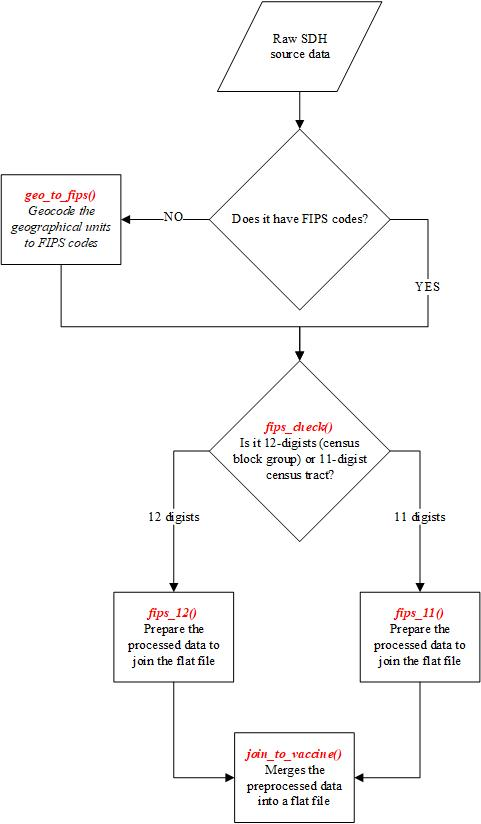

## Importing modules
Modules below are all essential. Please use the command below to install any module. 


from census import Census
from us import states
import pandas as pd 
import json
import requests
from urllib.request import urlopen
import time
import numpy as np
import glob
import zipfile
import requests, zipfile, io
from datetime import date 

In [ ]:
!pip install census us

In [20]:
from census import Census
from us import states
import pandas as pd 
import json
import requests
from urllib.request import urlopen
import time
import numpy as np
import glob
import zipfile
import requests, zipfile, io
from datetime import date 
from google.colab import files
from google.colab import data_table

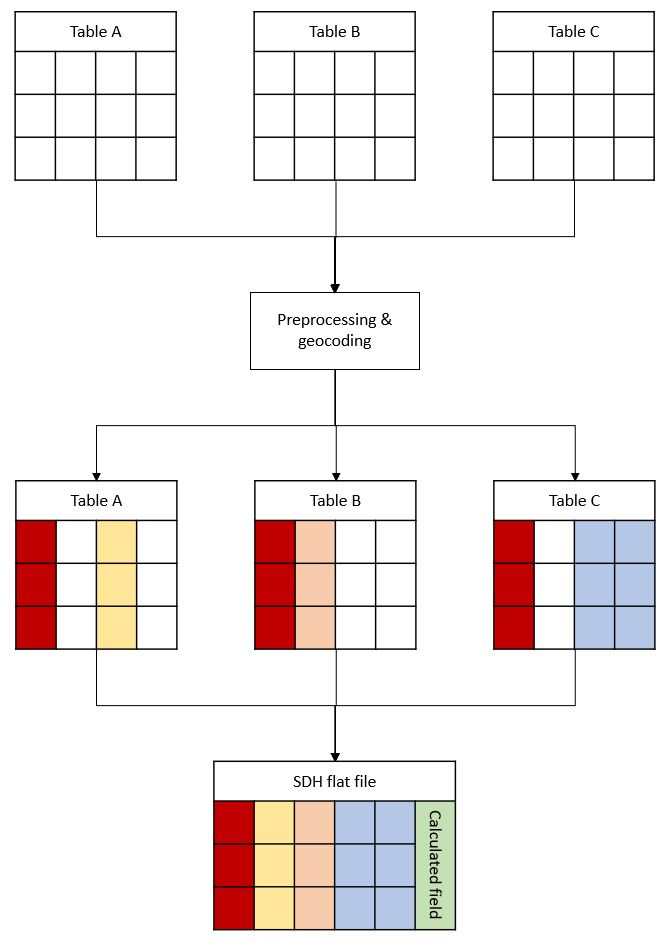

## American Community Survey (ACS)
We will use ACS's API to access its data.

It is important to note, the main SDH dataset should start with a column that includes all the geographical units of interest. We chose to start constructing VACCINe by incorporating ACS data since ACS provides data for **ALL** of FIPS codes. 

If you are not using ACS, you may obtain the list of geographical units of your area in a separate column in a dataframe as your starting point. Then you would be able to join additional datasets to this column. You can easily use ACS's API to generate the FIPS column.

### API setup
In order to use the API, you must acquire an API key. See address below:
https://api.census.gov/data/key_signup.html

To read the detailed API documentation, please visit the website below:
https://github.com/datamade/census 

Demystifying the Census API webinar: https://www.census.gov/data/academy/webinars/2020/demystifying-the-census-api.html?utm_campaign=20200722mscacs2ccstars&utm_medium=email&utm_source=govdelivery

In [7]:
c = Census("EnterYourUniqueKey")

### Organizing the variables of interest
We create a dictionary from the variables we want to include in the dataset along with a human-readable name for each. Note that you can name these variables based on your preference. For example, we know `B27010_023E` corresponds to the number of 18 to 34 years olds who only have Medicaid. We chose to name this variable `18_34y__MedcaidOnly`, however, you have the flexibility to name this based on your liking. 

This step will be crucial to "decode" ambiguous variable names in our dataset and rename the column headers.

To obtain a complete list of available variables please visit: https://www.census.gov/programs-surveys/acs/guidance/which-data-tool/table-ids-explained.html

In [9]:
dataHeadDict = {
    "NAME" : "Description",
    "B99051_001E":"fbTotal",
    "B99051_005E" : "foreignBorn",
    
    "B27010_033E" : "18_34y__NOinsurance", 
    "B27010_050E" : "35_64y__NOinsurance",
    "B27010_018E" : "18_34y__total",
    "B27010_034E": "35_64y__total", 
    "B27010_023E" : "18_34y__MedcaidOnly", 
    "B27010_039E" : "35_64y__MedcaidOnly",
    "B27010_029E" : "18_34y__Medicare/Medicaid",
    "B27010_046E" : "35_64y__Medicare/Medicaid", 
    
    "B15003_001E": "totalPop_b",
    "B15003_017E" : "high_school_diploma", 
    "B15003_018E" : "GED", 
    "B15003_002E" : "no_school", 
    "B15003_003E" : "nursery_school", 
    "B15003_004E" : "kindergarten", 
    "B15003_005E" : "grade1_school", 
    "B15003_006E" : "grade2_school", 
    "B15003_007E" : "grade3_school",
    "B15003_008E" : "grade4_school",
    "B15003_009E" : "grade5_school",
    "B15003_010E" : "grade6_school",
    "B15003_011E" : "grade7_school",
    "B15003_012E" : "grade8_school",
    "B15003_013E" : "grade9_school",
    "B15003_014E" : "grade10_school",
    "B15003_015E" : "grade11_school",
    "B15003_016E" : "grade12_school_no_diploma", 
    
    "B23025_005E" : "unemployed_labor_force_16up", 
    "B23025_002E" : "labor_force_16up", 
    
    "B19113_001E" : "medianHouseIncome", 
    
    "C17002_001E" : "totalPop_a", 
    "C17002_002E" : "estimateUnder_.50",
    "C17002_003E" : "estimate_.50_.99",
    
    "B19083_001E" : "GINI",
    "B01003_001E" : "totalPop"
}

censusCodes = list(dataHeadDict.keys())

All variables are taken from ACS 5 year estimate 2018 as listed above. `censusCodes` variable contains only the keys in `dataHeadDict` (i.e. the coded variable names).

In [10]:
#ACS 5 year estimate 2018.
acs5DataCT = c.acs5.get(censusCodes, geo = {'for': 'tract:*', 'in':'state:{}'.format(states.NY.fips)}, year =2018)
dfCT = pd.DataFrame(data = acs5DataCT)

#create census tract fips code 
dfCT['Census_Tract'] = dfCT['state'].map(str) + dfCT['county'].map(str) + dfCT['tract'].map(str)

# include only NYC in dfCT
dfCT = dfCT[(dfCT.county == '005')| (dfCT.county =='047')| (dfCT.county == '061') |(dfCT.county == '081')| (dfCT.county == '085')]

In [ ]:
data_table.DataTable(dfCT, include_index=False, num_rows_per_page=5)

You are not only limited to variables you can pull from ACS dataset. You can combine them when appropriate to derive new variables. Below we are calculate the percentage for some of these variables based on the total population of each geographical area.

In [22]:
dfCT['foriegnBornPercent'] = dfCT.B99051_005E / dfCT.B99051_001E *100
dfCT['woInsurance18_64Percent'] = (dfCT.B27010_033E + dfCT.B27010_050E) / (dfCT.B27010_018E + dfCT.B27010_034E)  *100
dfCT['medicaid18_64Percent'] = (dfCT.B27010_023E + dfCT.B27010_039E) / (dfCT.B27010_018E + dfCT.B27010_034E)  *100
dfCT['medicaid_Medicare18_64Percent'] = (dfCT.B27010_029E + dfCT.B27010_046E) / (dfCT.B27010_018E + dfCT.B27010_034E)  *100
dfCT['no_school_to_12_grade_no_diplomaPercent'] = (dfCT.B15003_002E + dfCT.B15003_003E + dfCT.B15003_004E +  dfCT.B15003_005E+ \
                                                dfCT.B15003_006E+  dfCT.B15003_007E+  dfCT.B15003_008E+  dfCT.B15003_009E+  \
                                               dfCT.B15003_010E+  dfCT.B15003_011E+  dfCT.B15003_012E+  dfCT.B15003_013E+  \
                                               dfCT.B15003_014E+  dfCT.B15003_015E+  dfCT.B15003_016E) / dfCT.B15003_001E  *100
dfCT['highSchool_GEDPercent'] = (dfCT.B15003_017E + dfCT.B15003_018E) / dfCT.B15003_001E  *100
dfCT['unemployedPercent'] = dfCT.B23025_005E / dfCT.B23025_002E *100

dfCT['medianHouseIncome'] = dfCT.B19113_001E 
dfCT['belowPovertyPercent'] = (dfCT.C17002_002E + dfCT.C17002_003E) / dfCT.C17002_001E *100 
dfCT['GINI'] = dfCT['B19083_001E'].apply(pd.to_numeric)
dfCT['totalPopulation'] = dfCT.B01003_001E

#remove original raw data 
dfCT = dfCT.drop(censusCodes, axis =1)
dfCT = dfCT.drop(['county','state','tract'], axis =1)
dfCT = dfCT.reset_index(drop = True)
dfCT.rename(columns={dfCT.columns[0]:'FIPS'}, inplace=True)

In [ ]:
data_table.DataTable(dfCT, include_index=False, num_rows_per_page=5)

## Air quality - Environmental Protection Agency
This data set has several useful variables. However, we are only using _Total Respiratory (hazard quotient)_.

### Reading the dataset
We access the dataset directly from EPA's website by reading the URL in pandas.

In [24]:
url_epa = "https://www.epa.gov/sites/production/files/2018-08/nata2014v2_national_resphi_by_tract_poll.xlsx"
epa_df = pd.read_excel(url_epa, sheet_name=0)

### Exploring the dataset
It's a good practice to explore the dataset at hand by looking at the column names (or data dictionary if available), some sample data.

In [26]:
epa_df.columns

Index(['State', 'EPA Region', 'County', 'FIPS', 'Tract', 'Population',
       'Total Respiratory (hazard quotient)', '1,2-EPOXYBUTANE',
       '1,3-DICHLOROPROPENE', '2-CHLOROACETOPHENONE',
       '2,4-TOLUENE DIISOCYANATE', '4,4'-METHYLENEDIPHENYL DIISOCYANATE (MDI)',
       'ACETALDEHYDE', 'ACROLEIN', 'ACRYLIC ACID', 'ACRYLONITRILE',
       'ANTIMONY COMPOUNDS', 'BERYLLIUM COMPOUNDS',
       'BIS(2-ETHYLHEXYL)PHTHALATE (DEHP)', 'CHROMIUM VI (HEXAVALENT)',
       'CHLORINE', 'CHLOROPRENE', 'COBALT COMPOUNDS', 'DIESEL PM',
       'DIETHANOLAMINE', 'EPICHLOROHYDRIN',
       'ETHYLENE DIBROMIDE (DIBROMOETHANE)', 'ETHYLENE GLYCOL', 'FORMALDEHYDE',
       'HEXACHLOROCYCLOPENTADIENE', 'HEXAMETHYLENE DIISOCYANATE',
       'HYDROCHLORIC ACID (HYDROGEN CHLORIDE [GAS ONLY])', 'MALEIC ANHYDRIDE',
       'METHYL BROMIDE (BROMOMETHANE)', 'METHYL ISOCYANATE',
       'METHYL METHACRYLATE', 'METHYLENE CHLORIDE', 'NICKEL COMPOUNDS',
       'NAPHTHALENE', 'NITROBENZENE', 'PHOSGENE', 'PHTHALIC ANHYDRIDE

In [ ]:
epa_df.sample(5)

### Preprocessing 
We can now start manipulating the original dataset using the predefined functions above.

Keep in mind this dataset has data from all states in the US. To use the functions above, we must filter out all the other states and counties.

In [30]:
# Saving the names of the boroughs of NYC (as they appear in the dataset) in an array.
FiveBoroughs = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
# Filtering out all the other states
epa = epa_df.loc[epa_df.State == 'NY']
# Filtering out all the counties except the five boroughs of NYC
epa = epa[epa["County"].isin(FiveBoroughs)]

We should now determine the geographical units of the original dataset. We could either do this by manually looking at the dataset or using `fips_check` function we defined earlier. The results ensure us we do not have any FIPS code longer than 11 digits.

In [ ]:
fips_check(epa, 'Tract')

We can now use the `fips_11()` function and save it in a new dataframe. As described above, this function will ensures we only get the columns of interest in our final dataset. However, in this case we need to remove the previous geogrpahical unit column, `Tract`. `fips_11()` creates a column, _CT_ which serves as the new geographical unit column.

In [33]:
epa_11 = fips_11(epa, ['Tract', 'Total Respiratory (hazard quotient)'])
epa_11.drop(columns='Tract', inplace=True)

## social Vulnerability Index (SVI)

The SVI is developed by CDC (https://svi.cdc.gov/data-and-tools-download.html) to evaluate community risk to hazardous events." Several factors, including poverty, lack of access to transportation, and crowded housing may weaken a community’s ability to prevent human suffering and financial loss in a disaster. These factors are known as social vulnerability" 

Centers for Disease Control and Prevention/ Agency for Toxic Substances and Disease Registry/ Geospatial Research, Analysis, and Services Program. Social Vulnerability Index 2016 Database New York. data-and-tools-download.html. Accessed on 2018.

### Reading the dataset
Similar to EPA's dataset, we read this dataset via direct URL from CDC's website.

In [34]:
url_svi = "https://svi.cdc.gov/Documents/Data/2016_SVI_Data/CSV/States/NewYork.csv"
svi_df = pd.read_csv(url_svi)

### Preprocessing the dataset
This dataset contains all counties in New York state. We only need the subset of the dataset for the 5 boroughs in NY.

In [35]:
FiveBoroughs = ['Bronx', 'Kings', 'New York', 'Queens', 'Richmond']
svi = svi_df[svi_df['COUNTY'].isin(FiveBoroughs)]

### Final step
We are now ready to use our predefined functions to trim the columns and the FIPS codes. In this case, we are using the `fips_11` function which ensures we are extracting census tract level data.

In [36]:
svi_11 = fips_11(svi, ['FIPS', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES'])
svi_11.drop(columns='FIPS', inplace=True)

## Food Access Research Atlas from Economic Research Service 

https://www.ers.usda.gov/data-products/food-access-research-atlas/ (Data is from 2015.  Data version downloaded was last updated 5/18/2017. Data was downloaded 2018).

This is a measure of food access based on supermarket accessibility
This is a binary variable of YES[1]/NO[0] low access to food.  (If an area has low food access, the value will be 1). 

### Reading the dataset

Similar to other datasets, we will be reading the dataset via URL from USDA's website.

In [37]:
url_food = "https://www.ers.usda.gov/webdocs/DataFiles/80591/DataDownload2015.xlsx?v=0"
food_df = pd.read_excel(url_food, sheet_name='Food Access Research Atlas')

### Preprocessing
This dataset also contains data elements for all states in the United States. We only want the five boroughs of NYC.

In [38]:
FiveBoroughs = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
food = food_df.loc[food_df.State == "New York"]
food = food[food["County"].isin(FiveBoroughs)]

### Final step

In [39]:
food_11 = fips_11(food, ["CensusTract", "LAhalfand10"])
food_11.drop(columns='CensusTract', inplace=True)

## NYC Open 

We used _NYC Open Data_ (https://opendata.cityofnewyork.us/), to access several datasets for many of the variables used in VACCINe.

- Trees
- Bus Stop 
- Subway Stops 
- Crime Data 

We downloaded a local copy of each dataset and converted pairs of latitude and longitude to FIPS code using the function defined above. We broke up the larger datasets into smaller subsets before conversion, to prevent potential API timeouts. In this walkthrough, we dedicate a section to using the `geo_to_fips` function. However, for the remainder of the walkthrough, we will use the already converted and local version of the datasets.


## Trees

This measure is a count of alive trees (according to NYC Open dataset) in each geographical area in 2015. 

https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

### Reading the dataset
We have uploaded the converted dataset on our GitHub repository, however, you may download the original dataset from the link above.

In [40]:
url_tree = "https://github.com/SajjadAbedian/SDH_variables/blob/master/treeLocation.zip?raw=true"
r = requests.get(url_tree)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
tree_df = pd.read_csv(z.open('treeLocation.csv')) 

In [ ]:
data_table.DataTable(tree_df, include_index=False, num_rows_per_page=5)

### Preprocessing
This dataset is a subset of the original data. We only selected trees with the status of _alive_. At this step, we only need to find the count of trees in each geographical unit. We use the _Census_Tract_ column to aggregate the rows. 

In [43]:
tree = fips_11(tree_df, ['fips', 'tree_id'])
tree_11 = pd.value_counts(tree['CT']).to_frame('tree_count')
tree_11['CT'] = tree_11.index

In [ ]:
data_table.DataTable(tree_11, include_index=False, num_rows_per_page=5)

## Bus shelters

This measure is not a count of subway lines but a binary YES[1]/NO[0] value. (Times square has multiple lines and more connected while some other borough stops will have only one subway line).

### Source
https://data.cityofnewyork.us/Transportation/Bus-Stop-Shelters/qafz-7myz 
The raw dataset has latitude and longitude coordinates along with a few other data points for each bus shelter in NYC.

For our purpose, we need to create a binary indicator for each geographical unit to identify areas with or without bus shelters. Another way of manipulating the raw dataset would be to count the number of bus shelters in each area. (Please see Tree dataset).

### Reading Raw Dataset
**NOTE** We are also reading a preprocessed file called `bus_df` which has the latitude and longitude pairs converted to FIPS code using the `geo_to_fips()` function.

In [48]:
url = "https://raw.githubusercontent.com/SajjadAbedian/SDH_variables/master/bustopLocation.csv"
bus_df = pd.read_csv(url)

### Creating Binary Indicators
In this step we first count the number of bus shelters in each geographical unit. As mentioned earlier, you could stop and use this data element as one of your variables.

In [49]:
bus = fips_11(bus_df, ['FIPS', 'Location'])
bus_11 = pd.value_counts(bus['CT']).to_frame('BusStopCount')

The next step is to flag the geographical units with at least one bus shelter with `1` and `0` for geographical units with no bus shelter.

In [50]:
bus_11['busStopYN'] = np.where(bus_11['BusStopCount'] > 0, 1, 0)
bus_11['CT'] = bus_11.index

In [ ]:
data_table.DataTable(bus_11, include_index=False, num_rows_per_page=5)

## Subway Stations & Subway Entrances 

To accurately identify geographical units with ACCESS to a subway line we need to look at subway entrances as well as subway stations. We need to combine both variables with an OR logical operator. The subway entrance and subway location are in slightly different census tracts or census block groups.  This happens if there are some subways on the border of a geographical area.  

For example, the central park has 6 subway stations but the surrounding census tracts do not appear to have subways.  The combination of the two data sets aims to better portray access to subway stations. We understand this to be a limitation of this variable, especially in smaller geographical areas.

This measure is not a count of subway lines but a binary YES[1]/NO[0] value. (Times square has multiple lines and more connected while some other borough stops will have only one subway line).

### Data Sources
#### Subway Stations
https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49

#### Subway Entrance
https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56 

### Reading the dataset
The raw datasets each have a row per subway line/entrance identified by latitude and longitude. Similar to other datasets, we are using a preprocessed dataset where we already converted the pair of latitudes and longitudes to FIPS codes.

In [52]:
url_loc = "https://raw.githubusercontent.com/SajjadAbedian/SDH_variables/master/subwayLocation.csv"
url_entrance = "https://raw.githubusercontent.com/SajjadAbedian/SDH_variables/master/subwayEntrance.csv"

subloc_df = pd.read_csv(url_loc)
subentrance_df = pd.read_csv(url_entrance)

### Creating Binary Indicators
In this step we first count the number of subway lines/entrances in each geographical unit.

In [54]:
subloc = fips_11(subloc_df, ['FIPS', 'NAME'])
subloc_11 = pd.value_counts(subloc['CT']).to_frame('SubwayCount')
subloc_11['station_yn'] = np.where(subloc_11['SubwayCount'] > 0, 1, 0)
subloc_11['CT'] = subloc_11.index

subentrance = fips_11(subentrance_df, ['FIPS', 'NAME'])
subentrance_11 = pd.value_counts(subentrance['CT']).to_frame('EntranceCount')
subentrance_11['entrance_yn'] = np.where(subentrance_11['EntranceCount'] > 0, 1, 0)
subentrance_11['CT'] = subentrance_11.index

### Combining the two variables
In this step, we need to combine the two variables in one. In other words, we need to create a final binary indicator where we assign `1` when a geographical area has either a subway station or a subway entrance and `0` for a geographical area has neither. We then save the results in a new data frame `subway`. We will complete this task at the end once we join all variables together.

## Crime
### Reading the original dataset
This dataset contains all Felonies, Misdemeanors, and Violations. In order to speed up the processing time, we suggest breaking up the dataset based on the crime types. You can further speed up the process by only selecting a few columns for your dataset (i.e. Latitude, Longitude, and LAW_CAT_CD).]

In this walkthrough, we briefly go over breaking up the dataset based on the crime type. However, due to the large size of the datasets, we will use a preprocessed dataset which contains converted latitudes and longitudes.

In [ ]:
# DO NOT RUN
# Steps below detail breaking up the crime dataset to smaller subsets according to the crime type
crime = pd.read_csv('NYPD_Complaint_Data_Historic.csv')
crime_felony = crime[crime['LAW_CAT_CD'] == 'FELONY']
crime_misdemeanor = crime[crime['LAW_CAT_CD'] == 'MISDEMEANOR']
crime_violation = crime[crime['LAW_CAT_CD'] == 'VIOLATION']

## Felony
### Reading the dataset

In [61]:
url_felony = "https://raw.githubusercontent.com/SajjadAbedian/SDH_variables/master/crimeLocationFelony.csv"
felony_df= pd.read_csv(url_felony)

### Preprocessing
Similar to the _tree_ dataset we need to get a count of felonies in each geographical unit.

In [62]:
felony = fips_11(felony_df, ['FIPS', 'LAW_CAT_CD'])
felony_11 = pd.value_counts(felony['CT']).to_frame('felony_count')
felony_11['felony_count'].fillna(0, inplace = True)
felony_11['CT'] = felony_11.index

## Violation
### Reading the dataset

In [56]:
url_violation = "https://raw.githubusercontent.com/SajjadAbedian/SDH_variables/master/crimeLocationViolation.csv"
violation_df= pd.read_csv(url_violation)

### Preprocessing
Similar to the _tree_ dataset we need to get a count of violations in each geographical unit.

In [57]:
violation = fips_11(violation_df, ['FIPS', 'LAW_CAT_CD'])
violation_11 = pd.value_counts(violation['CT']).to_frame('violation_count')
violation_11['violation_count'].fillna(0, inplace = True)
violation_11['CT'] = violation_11.index

## Misdemeanor
### Reading the dataset

In [58]:
url_misdemeanor = "https://raw.githubusercontent.com/SajjadAbedian/SDH_variables/master/crimeLocationMisdemeanor.csv"
misdemeanor_df= pd.read_csv(url_misdemeanor)

### Preprocessing
Similar to the _tree_ dataset we need to get a count of misdemeanors in each geographical unit.

In [59]:
misdemeanor = fips_11(misdemeanor_df, ['FIPS', 'LAW_CAT_CD'])
misdemeanor_11 = pd.value_counts(misdemeanor['CT']).to_frame('misdemeanor_count')
misdemeanor_11['misdemeanor_count'].fillna(0, inplace = True)
misdemeanor_11['CT'] = misdemeanor_11.index

## Putting it all together
We now have processed all datasets from different sources. We can now combine them all in one dataset. We start with the dataset that has **ALL** the FIPS code (in this case ACS, `dfCT`). 

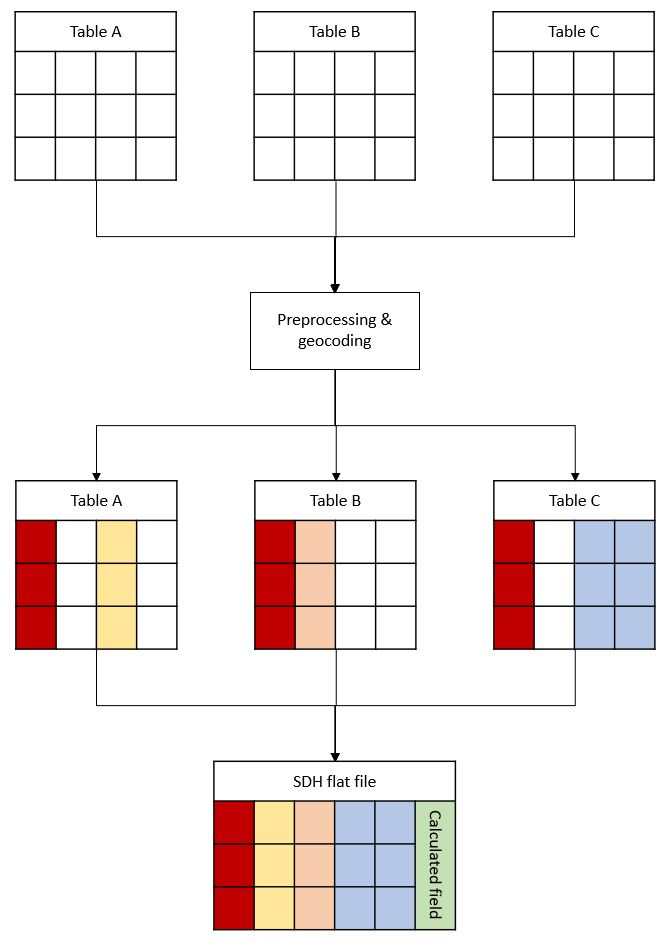

In [65]:
VACCINe = dfCT
VACCINe = join_to_vaccine(VACCINe, 'FIPS', epa_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', svi_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', food_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', tree_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', bus_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', subloc_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', subentrance_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', felony_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', violation_11, 'CT')
VACCINe = join_to_vaccine(VACCINe, 'FIPS', misdemeanor_11, 'CT')

## Creating derived variables
In this section, we use total population of each FIPS code (extracted from ACS dataset) and crime dataset to find the percentage of crime per 1000 people in each geographical unit. We then add these additional variables to the main dataset.

In [66]:
VACCINe['felonyPer1000PeoplePercent'] = (VACCINe.felony_count * 1000) / (dfCT.totalPopulation)
VACCINe['violationPer1000PeoplePercent'] = (VACCINe.violation_count * 1000) / (dfCT.totalPopulation)
VACCINe['misdemeanorPer1000PeoplePercent'] = (VACCINe.misdemeanor_count * 1000) / (dfCT.totalPopulation)
VACCINe['subway_yn'] = np.where(np.logical_or(VACCINe['station_yn'] == 1, VACCINe['entrance_yn'] == 1), 1,0)

## Data cleanup
Before exporting the dataset, we need to make sure we do a series of data cleanups. It includes removing values that are out of range. For example, replacing _-666666666_ from ACS dataset and _-999_ from SVI dataset with _-666_. This will help to unify all numbers that are flagged as out of range. We will also fill all NULL values with _-666_.

In [67]:
#remove values that are -666 from census tract data (low or zero populations)
VACCINe['medianHouseIncome'] = np.where(VACCINe['medianHouseIncome']== -666666666.0, -666, VACCINe['medianHouseIncome'])
VACCINe['GINI'] = np.where(VACCINe['GINI']== -666666666.0, -666, VACCINe['GINI'])
# remove -999 values from SVI (low or zero populations)
VACCINe['RPL_THEME1'] = np.where(VACCINe['RPL_THEME1']== -999.0000, -666, VACCINe['RPL_THEME1'])
VACCINe['RPL_THEME2'] = np.where(VACCINe['RPL_THEME2']== -999.0000, -666, VACCINe['RPL_THEME2'])
VACCINe['RPL_THEME3'] = np.where(VACCINe['RPL_THEME3']== -999.0000, -666, VACCINe['RPL_THEME3'])
VACCINe['RPL_THEME4'] = np.where(VACCINe['RPL_THEME4']== -999.0000, -666, VACCINe['RPL_THEME4'])
VACCINe['RPL_THEMES'] = np.where(VACCINe['RPL_THEMES']== -999.0000, -666, VACCINe['RPL_THEMES'])
# remove NaN values (from dividing by a population of zero )
VACCINe = VACCINe.fillna(value = -666)

In [ ]:
data_table.DataTable(VACCINe, include_index=False, num_rows_per_page=5)

## Exporting the final dataset
We can now confidently export the dataset into a .CSV file. It is good practice to inspect the dataset before exporting.

In [ ]:
list(VACCINe.columns.values)

In [70]:
VACCINe.to_csv('VACCINe_' + str(fips_check(VACCINe, 'FIPS')) + '_digits_fips_'+ str(date.today()) + '.csv')

In [71]:
files.download('VACCINe_' + str(fips_check(VACCINe, 'FIPS')) + '_digits_fips_'+ str(date.today()) + '.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>